In [14]:
import cv2 as cv
import numpy as np
from sklearn.decomposition import PCA
import os
import re
import glob
from scipy.ndimage import gaussian_filter1d

In [15]:
def get_out_folder(file_name):
    """
    Get the output folder path based on the input file name.
    """
    # Extract the number
    match = re.match(r"(\d+)_", file_name)
    if match:
        number = int(match.group(1))
    else:
        number = "unknown"

    # Check for 'query' or 'reference'
    if "query" in file_name:
        subfolder = "query"
    elif "reference" in file_name:
        subfolder = "reference"
    else:
        subfolder = "other"

    output_folder = os.path.join("frames", subfolder, f"vid_{number}")
    return output_folder

In [16]:
def extract_frames(video_path, output_folder, target_fps=15, max_pixels=120000):
    """
    Extract frames from a video and save them to the specified output folder.
    Args:
        video_path (str): Path to the input video file.
        output_folder (str): Path to the folder where frames will be saved.
    """
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            raise IOError(f"Cannot open video {video_path}")
        orig_fps = cap.get(cv.CAP_PROP_FPS) or target_fps
        frame_step = max(int(round(orig_fps / target_fps)), 1)

        orig_indices = []
        count = 0
        saved = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_step == 0:
                # Resize to max_pixels
                h, w = frame.shape[:2]
                scale = (max_pixels / float(w * h)) ** 0.5
                if scale < 1.0:
                    frame = cv.resize(frame, (int(w * scale), int(h * scale)), interpolation=cv.INTER_AREA)
                # Save frame
                cv.imwrite(os.path.join(output_folder, f"frame_{saved:04d}.jpg"), frame)
                orig_indices.append(count)
                saved += 1
            count += 1
        cap.release()
        
        return orig_fps, frame_step, orig_indices

In [17]:
def match_query_to_reference(video_file, pca_model=None, target_fps=15, max_pixels=120000):
    """
    Match query frames to reference frames using PCA for dimensionality reduction.
    Args:
        video_file (str): Path to the input video file.
        pca_model (PCA, optional): Pre-trained PCA model. If None, a new model will be created.
        pca_dim (int): Number of dimensions for PCA.
        lambda_val (float): Regularization parameter for PCA.
        fps (int): Frames per second for the video.
    Returns:
        tuple: Output folder path and PCA model.
    """
    # Determine folders and extract frames if needed
    print(f"Processing video file: {video_file}...")
    out_folder = get_out_folder(os.path.basename(video_file))
    orig_fps, frame_step, orig_indices = extract_frames(video_file, out_folder, target_fps, max_pixels)
    return out_folder, pca_model, orig_fps, frame_step, orig_indices

In [18]:
def compute_hof_for_frame(prev_gray, gray, num_bins=8):
    """
    Compute a histogram of optical flow (HOF) between prev_gray and gray.
    - prev_gray, gray: two consecutive grayscale frames
    - num_bins: number of orientation bins (e.g. 8 or 16)
    Returns a (num_bins,) numpy array of flow magnitudes per orientation bin.
    """
    # Compute dense flow
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray,
                                       None,
                                       pyr_scale=0.5,
                                       levels=3,
                                       winsize=15,
                                       iterations=3,
                                       poly_n=5,
                                       poly_sigma=1.2,
                                       flags=0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1], angleInDegrees=True)
    # Quantize angles into bins
    bin_edges = np.linspace(0, 360, num_bins+1)
    hof, _ = np.histogram(ang.flatten(), bins=bin_edges, weights=mag.flatten())
    # Normalize
    # if hof.sum() > 0:
    #     hof = hof / hof.sum()
    return hof

In [19]:
from tqdm import tqdm

def load_frame_descriptors(    
    frame_folder, sift,
    pca_model=None, pca_dim=64,
    fit_pca=False,
    raw_hof_bins=8,
    desired_hof_pca_dim=32
    ):
    # Could multithread
    
    """
    Returns:
      descriptors: np.ndarray of shape (T, pca_dim + hof_out_dim)
      pca_sift:    PCA model for SIFT
      pca_hof:     PCA model for HOF (or None)
      hof_out_dim: integer = number of HOF dims used
    """
    frame_paths = sorted(glob.glob(os.path.join(frame_folder, "frame_*.jpg")))

    # First pass: collect for PCA
    sift_feats = []
    hof_feats  = []
    prev_gray  = None

    for fp in tqdm(frame_paths, desc="Collecting descriptors for PCA and HOF"):
        img = cv.imread(fp, cv.IMREAD_GRAYSCALE)

        # Collect SIFT descriptors
        _, des = sift.detectAndCompute(img, None)
        if fit_pca and des is not None:
            sift_feats.append(des)

        # Collect raw HOF (sqrt‑normalized)
        if fit_pca and prev_gray is not None:
            raw_hof = compute_hof_for_frame(prev_gray, img, num_bins=raw_hof_bins)
            hof_feats.append(np.sqrt(raw_hof))

        prev_gray = img

    # Fit PCA on SIFT
    if fit_pca and sift_feats:
        stacked_sift = np.vstack(sift_feats)
        pca_sift = PCA(n_components=pca_dim, whiten=True, svd_solver='auto')
        pca_sift.fit(stacked_sift)
    else:
        pca_sift = pca_model  # may be None if called for reference

    # Fit PCA on HOF
    if fit_pca and hof_feats:
        hof_stacked = np.vstack(hof_feats)
        # maximum comps we can ask for
        max_comp = min(hof_stacked.shape[0], hof_stacked.shape[1])
        hof_out_dim = min(desired_hof_pca_dim, max_comp)
        pca_hof = PCA(n_components=hof_out_dim, whiten=True, svd_solver='auto')
        pca_hof.fit(hof_stacked)
    else:
        pca_hof    = None
        hof_out_dim = raw_hof_bins

    # Second pass: build frame vectors
    all_descs = []
    prev_gray = None
    for fp in tqdm(frame_paths, desc="Extracting frame vectors"):
        img = cv.imread(fp, cv.IMREAD_GRAYSCALE)

        # SIFT → PCA → mean
        _, des = sift.detectAndCompute(img, None)
        if des is not None and pca_sift is not None:
            des_pca = pca_sift.transform(des)
            sift_vec = np.mean(des_pca, axis=0)
        else:
            sift_vec = np.zeros(pca_dim, dtype=np.float32)

        # raw HOF → √ → PCA (or zeros)
        if prev_gray is not None:
            raw_hof = compute_hof_for_frame(prev_gray, img, num_bins=raw_hof_bins)
            raw_hof = np.sqrt(raw_hof)
            if pca_hof is not None:
                hof_vec = pca_hof.transform(raw_hof[np.newaxis, :])[0]
            else:
                hof_vec = np.zeros(hof_out_dim, dtype=np.float32)
        else:
            hof_vec = np.zeros(hof_out_dim, dtype=np.float32)

        prev_gray = img

        # Concatenate & normalize
        frame_vec = np.hstack([sift_vec, hof_vec])
        norm = np.linalg.norm(frame_vec)
        if norm > 1e-6:
            frame_vec /= norm
        all_descs.append(frame_vec)

    descriptors = np.vstack(all_descs)
    
        
    print(f"Extracted {len(all_descs)} frame vectors from {len(frame_paths)} frames.")
    # print(f"Shape of each frame vector: {all_descs[0].shape if all_descs else 'N/A'}")
    # print(f"Total number of frames processed: {len(all_descs)}")
    # print(f"Shape of all descriptors: {np.array(all_descs).shape}")
    # print(f"Shape of PCA model components: {pca_model.components_.shape if pca_model else 'N/A'}")
    return descriptors, pca_sift, pca_hof, hof_out_dim

In [20]:
def compute_cte_correlation(query_desc, ref_desc, lambda_val=1e-3):
    print("LAMBDA RECEVIED: ", lambda_val)
    
    Tq, D = query_desc.shape
    Tr, _ = ref_desc.shape
    N = 1 << int(np.ceil(np.log2(max(Tq, Tr))))
    
    N = max(len(query_desc), len(ref_desc))
    
    Q = np.zeros((N, D), dtype=np.float32)
    R = np.zeros((N, D), dtype=np.float32)
    Q[:Tq] = query_desc; R[:Tr] = ref_desc
    Qf = np.fft.rfft(Q, n=N, axis=0)
    Rf = np.fft.rfft(R, n=N, axis=0)
    num = np.sum(np.conj(Qf) * Rf, axis=1)
    den = np.sum(np.abs(Qf) ** 2, axis=1)
    scores = np.fft.irfft(num / (den + lambda_val), n=N)
    
    smoothed_scores = gaussian_filter1d(scores, sigma=3)
    
    return smoothed_scores

In [21]:
def find_best_offset(scores, fps=15):
    best_frame = int(np.argmax(scores))
    return best_frame, best_frame / fps

In [22]:
ground_truth = [
    585,
    756,
    650,
    360,
    340,
    560,
    590,
    1497,
    1196,
    1160,
    1120,
    450,
    636,
    610,
    1250
]

In [23]:
def evaluate_lambda(query_desc, ref_desc, true_frame, fps, r_map):
    best = {}
    lambda_vals = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
    for λ in lambda_vals:
        scores = compute_cte_correlation(query_desc, ref_desc, lambda_val=λ)
        
        scores = scores[:len(r_map)]  # only keep valid time shifts
        delta = np.argmin(scores)   
        
        delta, _ = find_best_offset(scores)
        
        delta = min(delta, len(r_map) - 1)
        
        pred_frame = r_map[delta]
        err = abs(pred_frame - true_frame)
        best[λ] = err
        
        print(f"delta = {delta} | Ground truth = {ground_truth[0]} | len(r_map) = {len(r_map)} | max delta allowed = {len(r_map)-1} | r_map[delta] = {r_map[delta]} | error for λ={λ}: {err} frames")
        print("")
        
        best_lambda = min(best, key=best.get)
    return best_lambda

In [24]:
from cnn_task1 import extract_cnn_frame_vectors

sift = cv.SIFT_create()
pca_model = None
results = []

videos_idx_limit = 15 # Limit to which video number we want to stop process (1 - 15)

for idx in range(7, videos_idx_limit + 1):
    q_file = f"train/task1/{idx:02d}_query.mp4"
    r_file = f"train/task1/{idx:02d}_reference.mp4"
    
    print(f"Processing video pair {idx:02d}: {q_file} (query) and {r_file} (reference)")
    
    # Process query video
    q_folder, pca_model, q_fps, q_step, q_map = match_query_to_reference(q_file, pca_model, target_fps=20, max_pixels=180000)
    print("first time fitting PCA on query frames")
    # q_desc, pca_sift, pca_hof, hof_dim = load_frame_descriptors(
    #     q_folder, sift,
    #     pca_model=None,
    #     pca_dim=128,
    #     fit_pca=True,
    #     raw_hof_bins=8,
    #     desired_hof_pca_dim=32
    # )
    q_desc, pca_cnn = extract_cnn_frame_vectors(q_folder, pca_model=None, pca_dim=256)
    
    
    # Process reference video
    r_folder, _, r_fps, r_step, r_map = match_query_to_reference(r_file, pca_model, target_fps=20, max_pixels=180000)
    
    print("Extracting reference frames")
    # r_desc, _, _, _ = load_frame_descriptors(
    #     r_folder, sift,
    #     pca_model=pca_sift,
    #     pca_dim=128,
    #     fit_pca=False,
    #     raw_hof_bins=8,
    #     desired_hof_pca_dim=32
    # )    
    r_desc, _      = extract_cnn_frame_vectors(r_folder, pca_model=pca_cnn, pca_dim=256)

    
    best_lambda = evaluate_lambda(q_desc, r_desc, ground_truth[idx-1], 30, r_map)

    scores = compute_cte_correlation(q_desc, r_desc, lambda_val=best_lambda)
    scores = scores[:len(r_map)]

    print(f"Scores: {scores[:10]}")  # Print first 10 scores for verification
    best_frame, best_time = find_best_offset(scores, fps=30)
    results.append((idx, best_frame, best_time))
    print(f"Pair {idx:02d}: offset {best_frame} frames ({best_time:.2f}s)")
    


Processing video pair 07: train/task1/07_query.mp4 (query) and train/task1/07_reference.mp4 (reference)
Processing video file: train/task1/07_query.mp4...
first time fitting PCA on query frames
Processing video file: train/task1/07_reference.mp4...
Extracting reference frames
LAMBDA RECEVIED:  0.01
delta = 57 | Ground truth = 585 | len(r_map) = 600 | max delta allowed = 599 | r_map[delta] = 171 | error for λ=0.01: 419 frames

LAMBDA RECEVIED:  0.001
delta = 57 | Ground truth = 585 | len(r_map) = 600 | max delta allowed = 599 | r_map[delta] = 171 | error for λ=0.001: 419 frames

LAMBDA RECEVIED:  0.0001
delta = 57 | Ground truth = 585 | len(r_map) = 600 | max delta allowed = 599 | r_map[delta] = 171 | error for λ=0.0001: 419 frames

LAMBDA RECEVIED:  1e-05
delta = 57 | Ground truth = 585 | len(r_map) = 600 | max delta allowed = 599 | r_map[delta] = 171 | error for λ=1e-05: 419 frames

LAMBDA RECEVIED:  1e-06
delta = 57 | Ground truth = 585 | len(r_map) = 600 | max delta allowed = 599 | 

In [25]:
frame_tolerance = 60  # Tolerance in frames for accuracy calculation
accuracy = np.mean([abs(gt - bf) <= frame_tolerance for gt, (_, bf, _) in zip(ground_truth, results)])
difference = [abs(gt - bf) for gt, (_, bf, _) in zip(ground_truth, results)]
print(f"Ground truth differences: {difference}")
print(f"Accuracy: {accuracy:.2%} (±{frame_tolerance} frames tolerance)")

Ground truth differences: [528, 309, 207, 330, 313, 404, 239, 1233, 931]
Accuracy: 0.00% (±60 frames tolerance)


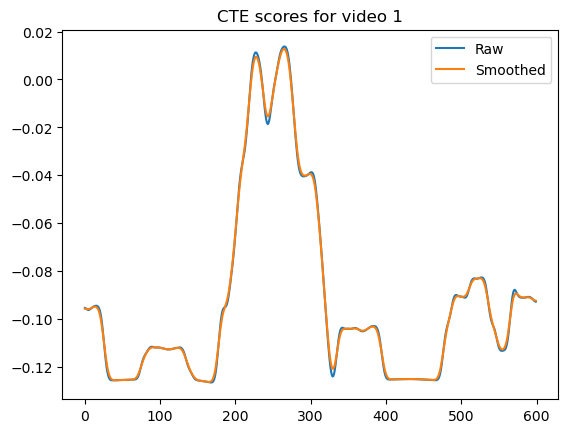

In [26]:
import matplotlib.pyplot as plt

plt.plot(scores, label="Raw")
plt.plot(gaussian_filter1d(scores, sigma=3), label="Smoothed")
plt.title("CTE scores for video 1")
plt.legend()
plt.show()